# Phase 3 Data Science Report

In [2]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import statistics as st
from functions import* 

hypermodel = tf.keras.models.load_model('output/my_model')

# Introduction

It is of interest to have a model that is able determine the probability that the given image contains automobile. In order to train the model to do the following, CIFAR-10 dataset is initially provided. This dataset can be fed into tensorflow keras model that uses neural network to recognise underlying relationships in a set of images. The goal of this model is to accurately detect the presence of automobile in the given image and calculate how convincing this result is.

# Model Process

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 different labels. Each label follows as shown below.

* airplane
* automobile
* bird
* cat
* deer
* dog
* rog
* horse
* ship
* truck 

Using this dataset, 40000 training and 8000 test images are attained, each containing same number of images in each label. This is to avoid class imbalance in dataset which can later cause accuracy issue of the model. Before the data is used for training, there are several layers that needs to be specified in the keras model. 

Firstly, keras preprocessing layers such as RandomFlip, RandomRotation, and RandomZoom are used to implement data augmentation. This takes the approach of generating additional training data from existing images by augmenting them using random transformations. This helps expose the model to more aspects of the data and generalize better (prevents overfitting). The image of cat is augmented several times to visualise the effect as shown below.

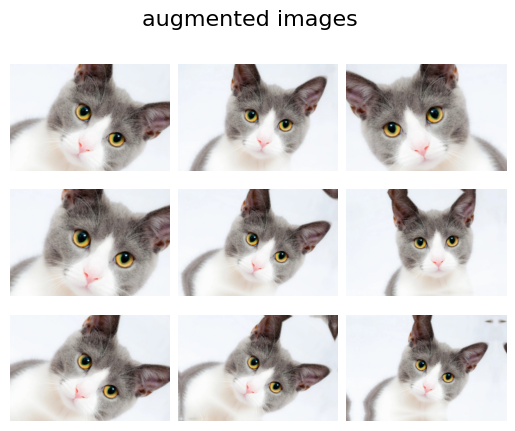

In [3]:
Image.open('image/cat_augmented_image.png')


The next layers applied to the keras model are Conv2D and MaxPooling2D. The convolution layer extracts certain features from an training images and pooling layer is used to reduce the spatial dimension of generated feaures. This approach allows to create a lower resolution version of image input that still contains the important features without the fine detail that may not be as useful to the task. The model summary below show how shape changes over each layers.

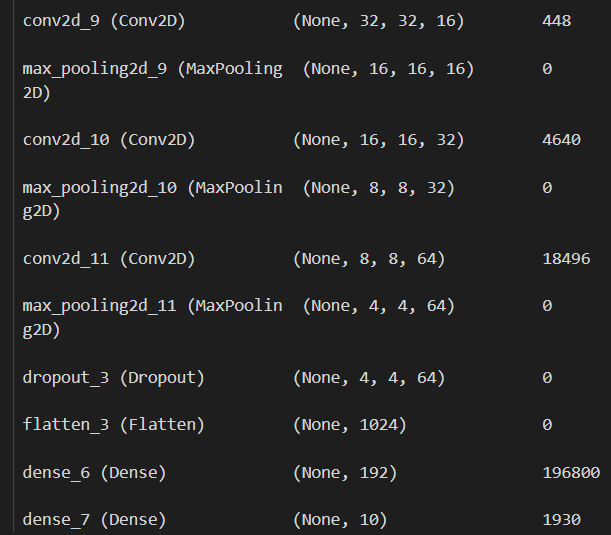

In [4]:
Image.open('image/layers.png')

The dropout layer is another technique to reduce overfitting by introducing dropout reglarization to the network (Nitish Srivastava, et al. 2014). This layer does not alter the shape of output but instead it removes a number of output units from the layer during the training processThe network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) and passes through dense layers to get 10 output class which corresponds to the number of labels in test and training images.

Finally, compiling a model is required to finalise the model and make it completely ready to use. For compilation, there are two things that needs to be specified, an loss function and an optimizer. For the loss function, sparse categorical crossentropy is chosen as output classes are mutually exclusive meaning each sample belongs exactly to one class. For the optimizer, adam is selected for following reasons:
* Straightforward to implement.
* Little memory requirements.
* Well suited for problems that are large in terms of data.
* Hyper-parameters have intuitive interpretation and typically require little tuning.
For the last line, learning rate is one hyper-parameter in adam optimizer and it turns out that it matches default value of 0.001 (see later).

Once the layer set up for keras model is completed, the training images can fed into the keras model. However, it is very confusing to choose parameters that are appropriate for some layers such as units in dense layer, droupout ratio and learning rate of the model. One well known solution to this is hyperparameter tuning that is choosing a set of optimial parameters for training the model. Since, the goal of this project is to build the model that is able to accurately predict presence of automobile from any images, the objective of hyperparameter tuning is set to validation accuracy. The result below was attained, using keras Hyperband Tuner.

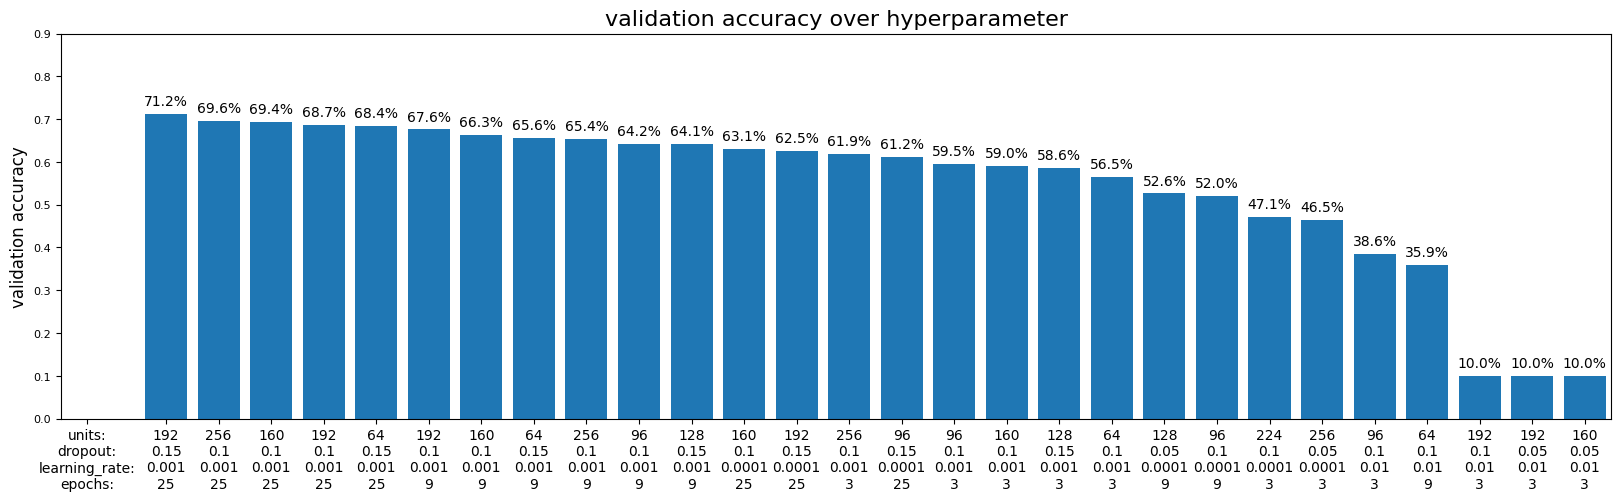

In [5]:
Image.open('image/hypertune.png')

Hyperparamer tuning was very time consuming procedure as it uses range of values for each parameter to find optimal parameters. To make more efficient use of Hyperband Tuner, the maximum number of training iteration is set to 25 with stopping criteria if the model validation accuracy is not improving quickly enough. In this way, 192 for units in dense layer, 0.15 for dropout ratio and 0.001 for learning rate are attained as optimal parameter for final keras model. 

# Model Performance

The model is then trained again with full training iteration to study the behavior of accuracy/loss and validation accuracy/loss. 

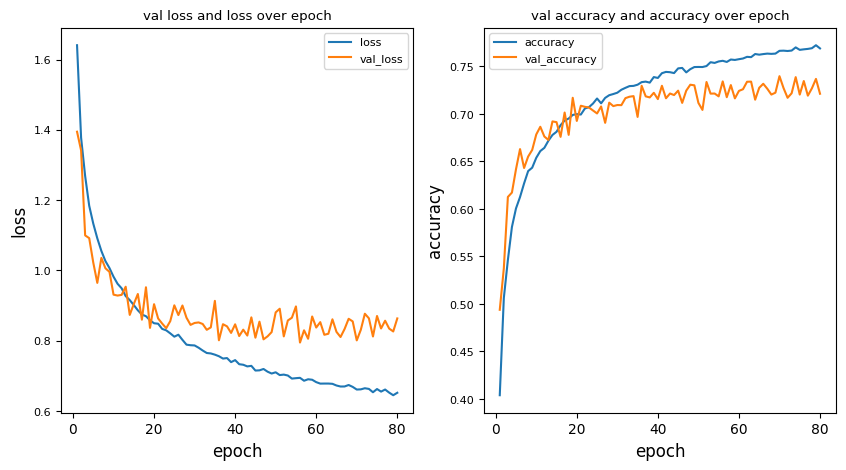

In [9]:
Image.open('image/accuracylossplot.png')

It is noticeable that validation loss is least and accuracy is highest at value of around 60 epoch. At this point, it is good to stop the training iteration and maximum validaton accuracy is recorded at epoch of 70. The model accuracy and loss are continuously improving which is a good example of overfitting the model and should avoid any further training iteration. Finally, the model is trained again with epoch of 70 to replicate the model result when validation accuracy is highest. The model is then used to see how well it predict test images.

In [7]:
label_names,test_labels,test_images=load_image_data()
# result
eval_result = hypermodel.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)

250/250 [==============================] - 2s 8ms/step - loss: 0.8277 - accuracy: 0.7374
[test loss, test accuracy]: [0.8277215361595154, 0.737375020980835]


In [10]:
# probability matrix
predictions=hypermodel.predict(tf.expand_dims(test_images[1], 0),verbose=0)
print(tf.nn.softmax(predictions[0]).numpy())

[8.4201837e-01 8.0380822e-03 1.2763505e-04 8.6614593e-05 4.6041206e-09
 2.2406427e-07 1.1632485e-07 1.1685912e-07 1.3608427e-01 1.3644470e-02]


The model have loss of 0.83 and validation accuracy of 0.74 as expected from the previous plot. The current model returns one output, a probability matrix that shows how confident each label matches the image and the index represent labels. This is implemented so that it returns two output, probability that automobile is in the image and a number, 1 if automobile in most likely in the image, 0 otherwise.

In [38]:
# calculation for 95 confidence interval
label,percent=predict(test_images)
result=label==(test_labels==1) # 1 indicate correct prediction
percent=np.mean(result)
interval=1.96*np.std(result)/np.sqrt(8000)
print("95% confidence interval lie between {:.5f} and {:.5f}".format(percent-interval,percent+interval))
# for 95 confidence interval for biased input
print("when input with one type of images")
for i in range(10):
    test=test_images[np.where(test_labels==i)] # only one type of image is inputted
    label,percent=predict(test)
    if i==1:
        result=np.array(label)==1 #when inputted with automobile images
    else:
        result=np.array(label)!=1 #when inputted with images other than automobile images
    percent=np.mean(result)
    interval=1.96*np.std(result)/np.sqrt(8000)
    print("{:.5f} and {:.5f} for {} images".format(percent-interval,percent+interval,label_names[i]))


95% confidence interval lie between 0.95557 and 0.96418
when input with one type of images
0.96229 and 0.97021 for airplane images
0.91018 and 0.92232 for automobile images
0.97828 and 0.98422 for bird images
0.97025 and 0.97725 for cat images
0.98782 and 0.99218 for deer images
0.98644 and 0.99106 for dog images
0.97559 and 0.98191 for frog images
0.98098 and 0.98652 for horse images
0.92700 and 0.93800 for ship images
0.88058 and 0.89442 for truck images


The result is re-evaluated with test images and it is confident that the model is able to detect the presence of automobile correctly for between 95.6% and 96.4% of the time. The model is also evaluated with each type of images to analyse the performance of automobile detection model over different type of images. It seems each label has reasonably accurate result but slightly lower accuracy on automobile, ship and truck than other labels. This may due to following three labels haveing less distinctive features than others. Therefore, it would be more difficult for the model to learn how to distinguish among automobile, ship and truck, resulting in lower accuracy.

To test how well the model works with higher resolution images, 2 images of cat and automobile are randomly selected from Google image and input to the model. The result is as shown below.

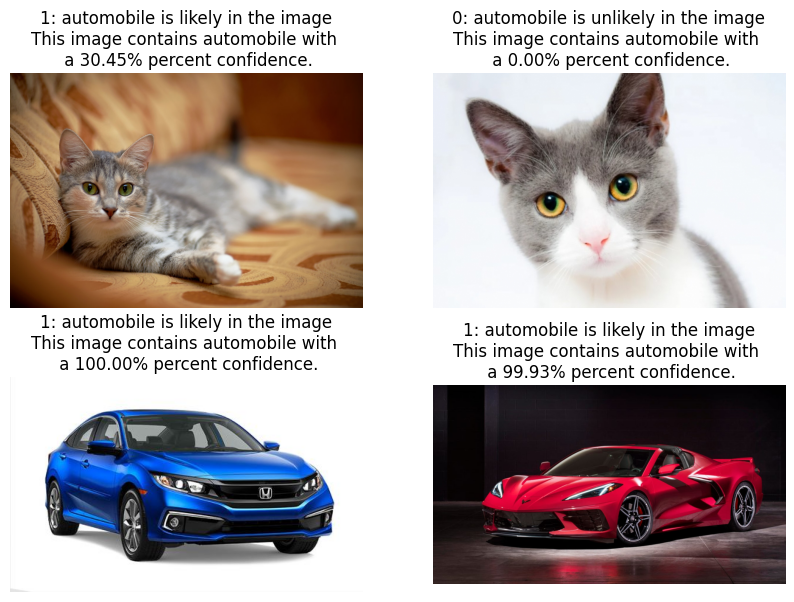

In [8]:
Image.open('image/test.png')

These images are inconsistent with image size used for training the model so they are first passed through keras preprocessing layer that automatically resize the image to 32x32. The result is reasonably accurate for all images but failed to predict that automobile is in fact not in the first image. 

# Conclusion

Overall, the model is successfully implemented so that it is able to detect automobile in any image. The model accuracy is improved using hyperparameter tuning where optimal parameters for keras layer are 192 for units in dense layer, 0.15 for dropout ratio and 0.001 for learning rate. It is confident that the accuracy of automobile detection model lies between 95.6% and 96.4%. However, the accuracy can result around 88.1% to 89.4 in the worst case where all input images are similar-looking to automobile.  

# References

1. [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer,), Nitish Srivastava, et al. 2014.